In [ ]:
# Cell 1: imports and load CSV
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# load your dataset
csv_path = r"C:\Global stat solutions\bidrecommendation.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Shape: (156733, 51)
Columns: ['BidId', 'BidFileNumber', 'BidName', 'BidDate', 'Bid_DueDate', 'BidFee', 'TargetTime', 'WinProbability', 'BidStatusName', 'Bid_JobPurpose', 'Bid_Deliverable', 'Market', 'Submarket', 'BusinessSegment', 'BusinessSegmentDetail', 'DistanceInMiles', 'Bid_Property_Type', 'PropertyId', 'OfficeId', 'PropertyName', 'PropertyType', 'SubType', 'PropertyCity', 'PropertyState', 'RooftopLongitude', 'RooftopLatitude', 'ZipCode', 'JobCount', 'IECount', 'LeaseCount', 'SaleCount', 'MarketOrientation', 'AddressDisplayCalc', 'GrossBuildingAreaRange', 'YearBuiltRange', 'OfficeCode', 'OfficeCompanyName', 'OfficeLocation', 'JobId', 'JobName', 'JobStatus', 'PopulationEstimate', 'AverageHouseValue', 'IncomePerHousehold', 'MedianAge', 'DeliveryTotal', 'NumberofBusinesses', 'NumberofEmployees', 'ZipPopulation', 'BidCompanyName', 'BidCompanyType']


In [ ]:
# Cell 2: convert BidDate to datetime and extract time components
df['BidDate'] = pd.to_datetime(df['BidDate'], errors='coerce')
df = df.dropna(subset=['BidDate']).reset_index(drop=True)

df['BidWeek'] = df['BidDate'].dt.isocalendar().week
df['BidMonth'] = df['BidDate'].dt.month
df['BidYear'] = df['BidDate'].dt.year

print("Date range:", df['BidDate'].min(), "to", df['BidDate'].max())
display(df[['BidDate','BidWeek','BidMonth','BidYear']].head())


Date range: 2018-01-02 00:00:00 to 2025-09-07 00:00:00


,BidDate,BidWeek,BidMonth,BidYear
0,2025-09-07,36,9,2025
1,2025-09-07,36,9,2025
2,2025-09-07,36,9,2025
3,2025-09-05,36,9,2025
4,2025-09-05,36,9,2025


In [ ]:
# Cell 3: Aggregate weekly median BidFee per ZipCode
agg = (
    df.groupby(['ZipCode','BidYear','BidWeek'])
    .agg(median_BidFee=('BidFee','median'))
    .reset_index()
)

print("Aggregation shape:", agg.shape)
display(agg.head())


Aggregation shape: (68060, 4)


,ZipCode,BidYear,BidWeek,median_BidFee
0,0,2018,7,4200.0
1,0,2018,8,4800.0
2,0,2018,9,5000.0
3,0,2018,13,3250.0
4,0,2018,15,1612.5


In [ ]:
# Cell 4: Create lag and rolling features per ZipCode
for lag in [1, 2, 3, 4]:
    agg[f'lag_{lag}'] = agg.groupby('ZipCode')['median_BidFee'].shift(lag)

# rolling average (4-week window)
agg['roll_4w'] = (
    agg.groupby('ZipCode')['median_BidFee']
    .shift(1)
    .rolling(window=4, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Drop rows without sufficient lag data
agg = agg.dropna(subset=['lag_1','lag_2','lag_3']).reset_index(drop=True)
print("After lag creation:", agg.shape)
display(agg.head())


After lag creation: (48463, 9)


,ZipCode,BidYear,BidWeek,median_BidFee,lag_1,lag_2,lag_3,lag_4,roll_4w
0,0,2018,13,3250.00,5000.00,4800.00,4200.0,NaN,4666.666667
1,0,2018,15,1612.50,3250.00,5000.00,4800.0,4200.0,4312.500000
2,0,2018,21,4668.75,1612.50,3250.00,5000.0,4800.0,3665.625000
3,0,2018,28,3500.00,4668.75,1612.50,3250.0,5000.0,3632.812500
4,0,2018,31,2000.00,3500.00,4668.75,1612.5,3250.0,3257.812500


In [ ]:
# Cell 5: Define target y as next week's median_BidFee
agg['target_next_week'] = agg.groupby('ZipCode')['median_BidFee'].shift(-1)

# Remove rows where target is missing
mask_good = np.isfinite(agg['target_next_week'].astype(float))
print("Dropping", int((~mask_good).sum()), "rows with missing target")

agg_clean = agg.loc[mask_good].reset_index(drop=True)
y = agg_clean['target_next_week']
print("Cleaned agg:", agg_clean.shape, " | Target length:", len(y))


Dropping 3705 rows with missing target
Cleaned agg: (44758, 10)  | Target length: 44758


In [ ]:
# Cell 6: Define features and clean missing values
features = ['lag_1','lag_2','lag_3','lag_4','roll_4w']
X = agg_clean[features].copy()

# Fill missing with median
for c in X.columns:
    if X[c].isna().any():
        X[c].fillna(X[c].median(), inplace=True)

print("X shape:", X.shape)
display(X.head())


X shape: (44758, 5)


,lag_1,lag_2,lag_3,lag_4,roll_4w
0,5000.00,4800.00,4200.0,2800.0,4666.666667
1,3250.00,5000.00,4800.0,4200.0,4312.500000
2,1612.50,3250.00,5000.0,4800.0,3665.625000
3,4668.75,1612.50,3250.0,5000.0,3632.812500
4,3500.00,4668.75,1612.5,3250.0,3257.812500


In [ ]:
# Cell 7: Train and evaluate with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

fold_rmse, fold_mae = [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    fold_rmse.append(rmse)
    fold_mae.append(mae)
    print(f"Fold {fold+1}: RMSE={rmse:.2f}, MAE={mae:.2f}")

print("\nAverage RMSE:", np.mean(fold_rmse))
print("Average MAE:", np.mean(fold_mae))


Fold 1: RMSE=2214.91, MAE=1295.65
Fold 2: RMSE=2025.85, MAE=1134.24
Fold 3: RMSE=1636.67, MAE=1077.25
Fold 4: RMSE=1995.27, MAE=1007.65
Fold 5: RMSE=3149.73, MAE=1290.48

Average RMSE: 2204.4853263864443
Average MAE: 1161.0529203628598


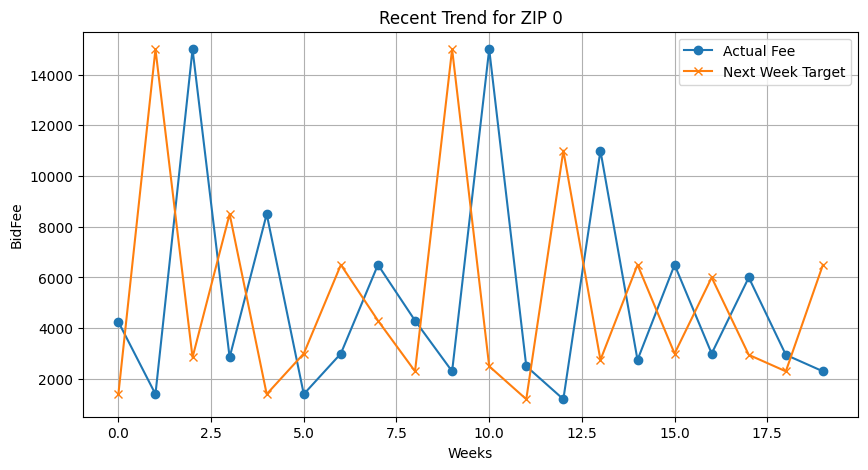

In [ ]:
# Cell 8: Visualize prediction trend for one ZipCode
sample_zip = agg_clean['ZipCode'].iloc[0]
zip_df = agg_clean[agg_clean['ZipCode']==sample_zip].copy()
zip_df = zip_df.tail(20)

plt.figure(figsize=(10,5))
plt.plot(zip_df['median_BidFee'].values, label='Actual Fee', marker='o')
plt.plot(zip_df['target_next_week'].values, label='Next Week Target', marker='x')
plt.title(f"Recent Trend for ZIP {sample_zip}")
plt.xlabel("Weeks")
plt.ylabel("BidFee")
plt.legend()
plt.grid(True)
plt.show()
